# 0) Imports and Installs

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

In [ ]:


from tqdm import tqdm

# Initialize a cache dictionary
symbol_cache = {}

def get_company_info_with_cache(symbol):
    if symbol in symbol_cache:
        return symbol_cache[symbol]

    try:
        ticker = yf.Ticker(symbol)
        info = ticker.info
        result = {
            'sector': info.get('sector', None),
            'description': info.get('longBusinessSummary', None)
        }
    except Exception:
        result = {
            'sector': None,
            'description': None
        }

    symbol_cache[symbol] = result
    time.sleep(1)  # Be respectful of rate limits
    return result

# 1) [Code Snippet 1] IPOs data from Web

* learn dataframes "stacking" (UNION ALL)
* learn about type casting
* generate new columns (simple and with function)


In [4]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [5]:
ipos_2023 = get_ipos_by_year(2023)
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      153 non-null    object
 1   Symbol        153 non-null    object
 2   Company Name  153 non-null    object
 3   IPO Price     153 non-null    object
 4   Current       153 non-null    object
 5   Return        153 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [6]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [7]:
ipos_2025 = get_ipos_by_year(2025)
ipos_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      152 non-null    object
 1   Symbol        152 non-null    object
 2   Company Name  152 non-null    object
 3   IPO Price     152 non-null    object
 4   Current       152 non-null    object
 5   Return        152 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [8]:

print(f"2023 count: {len(ipos_2023)}, 2024 count: {len(ipos_2024)}, 2025 count: {len(ipos_2025)}")

2023 count: 153, 2024 count: 225, 2025 count: 152


In [9]:
# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2025, ipos_2024, ipos_2023], ignore_index=True)

In [10]:
stacked_ipos_df.head(2)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Jun 13, 2025",AIRO,"AIRO Group Holdings, Inc.",$10.00,$24.00,140.00%
1,"Jun 13, 2025",BACC,Blue Acquisition Corp.,$10.00,$10.03,0.30%


In [11]:
# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      530 non-null    object
 1   Symbol        530 non-null    object
 2   Company Name  530 non-null    object
 3   IPO Price     530 non-null    object
 4   Current       530 non-null    object
 5   Return        530 non-null    object
dtypes: object(6)
memory usage: 25.0+ KB


In [125]:
import os
import pandas as pd
from datetime import datetime
from tqdm import tqdm

# Function to get latest IPOs
def get_latest_ipos():
    # Get the current year
    current_year = datetime.now().year
    
    # Years to check for IPOs (current and previous)
    years_to_check = [current_year, current_year-1]
    
    # Collect new IPO data
    new_ipos_list = []
    for year in years_to_check:
        ipos_df = get_ipos_by_year(year)
        if not ipos_df.empty:
            ipos_df['Year'] = year  # Add year column for reference
            new_ipos_list.append(ipos_df)
    
    if new_ipos_list:
        # Combine all new IPOs into one dataframe
        new_stacked_ipos_df = pd.concat(new_ipos_list, ignore_index=True)
        
        # Clean and prepare the dataframe (similar to your existing code)
        new_stacked_ipos_df['IPO Date'] = pd.to_datetime(new_stacked_ipos_df['IPO Date'], format='mixed')
        
        return new_stacked_ipos_df
    else:
        return pd.DataFrame()

# Load existing enriched IPOs if available
if os.path.exists('enriched_ipos.csv'):
    existing_ipos_df = pd.read_csv('enriched_ipos.csv')
    # Convert IPO Date to datetime for proper comparison
    existing_ipos_df['IPO Date'] = pd.to_datetime(existing_ipos_df['IPO Date'], format='mixed')
    
    # Get latest IPOs
    new_ipos_df = get_latest_ipos()
    
    if not new_ipos_df.empty:
        # Find truly new IPOs by comparing Symbol and IPO Date
        existing_keys = set(zip(existing_ipos_df['Symbol'], existing_ipos_df['IPO Date']))
        new_ipos_df['is_new'] = ~new_ipos_df.apply(lambda row: (row['Symbol'], row['IPO Date']) in existing_keys, axis=1)
        
        # Filter to only genuinely new IPOs
        truly_new_ipos = new_ipos_df[new_ipos_df['is_new']].drop(columns=['is_new'])
        
        if not truly_new_ipos.empty:
            print(f"Found {len(truly_new_ipos)} new IPOs to add to the dataset")
            
            # Append new IPOs to existing ones
            stacked_ipos_df = pd.concat([existing_ipos_df, truly_new_ipos], ignore_index=True)
            
            # Apply enrichment only to new IPOs
            if 'sector' in stacked_ipos_df.columns and 'description' in stacked_ipos_df.columns:
                # For new entries that don't have sector/description
                needs_enrichment = stacked_ipos_df[
                    stacked_ipos_df['sector'].isna() | stacked_ipos_df['description'].isna()
                ].copy()
                
                # Apply enrichment only to missing rows
                if not needs_enrichment.empty:
                    print(f"Enriching {len(needs_enrichment)} IPOs with sector and description data...")
                    enriched = needs_enrichment['Symbol'].progress_apply(get_company_info_with_cache).apply(pd.Series)
                    stacked_ipos_df.update(enriched)
            else:
                # First time adding these columns
                print("Enriching new IPOs with sector and description data...")
                stacked_ipos_df[['sector', 'description']] = (
                    stacked_ipos_df['Symbol']
                    .progress_apply(get_company_info_with_cache)
                    .apply(pd.Series)
                )
            
            # Save the updated DataFrame
            stacked_ipos_df.to_csv('enriched_ipos.csv', index=False)
            print(f"Saved updated dataset with {len(stacked_ipos_df)} total IPOs")
        else:
            print("No new IPOs found to add")
            stacked_ipos_df = existing_ipos_df
    else:
        print("No new IPO data available")
        stacked_ipos_df = existing_ipos_df
else:
    # First time running - collect all IPO data
    print("No existing IPO data found. Creating new dataset...")
    
    # Collect IPO data for 2023 to current year
    years = list(range(2023, datetime.now().year + 1))
    
    ipos_list = []
    for year in years:
        ipos_df = get_ipos_by_year(year)
        if not ipos_df.empty:
            ipos_df['Year'] = year  # Add year column for reference
            ipos_list.append(ipos_df)
    
    if ipos_list:
        # Combine all years into one dataframe
        stacked_ipos_df = pd.concat(ipos_list, ignore_index=True)
        
        # Clean and prepare the dataframe
        stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')
        
        # Enriching with sector and description
        print("Enriching IPO data with sector and description information...")
        stacked_ipos_df[['sector', 'description']] = (
            stacked_ipos_df['Symbol']
            .progress_apply(get_company_info_with_cache)
            .apply(pd.Series)
        )
        
        # Save the enriched DataFrame
        stacked_ipos_df.to_csv('enriched_ipos.csv', index=False)
        print(f"Saved new dataset with {len(stacked_ipos_df)} IPOs")
    else:
        stacked_ipos_df = pd.DataFrame()
        print("No IPO data available")

# Display the first 10 rows of the final dataframe
stacked_ipos_df.head(10)

Found 9 new IPOs to add to the dataset
Enriching 74 IPOs with sector and description data...


AttributeError: 'Series' object has no attribute 'progress_apply'

In [13]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [15]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,sector,description,Year


In [16]:
# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9

# Clean string formatting first
stacked_ipos_df['IPO Price'] = (
    stacked_ipos_df['IPO Price']
        .astype(str)  # Make sure we are working with strings
        .str.replace('$', '', regex=False)
        .replace(['-', 'TBD', ''], pd.NA)  # Handle known non-numeric placeholders
)

# Then convert to numeric with coercion
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'], errors='coerce')

# Ensure the dtype is float64 explicitly
stacked_ipos_df['IPO Price'] = stacked_ipos_df['IPO Price'].astype('float64')

stacked_ipos_df

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,sector,description,Year
0,2025-06-06,OMDA,"Omada Health, Inc.",19.0,23.0,0.2105,NaN,NaN,NaN
1,2025-06-05,CRCL,"Circle Internet Group, Inc.",31.0,107.7,2.4742,NaN,NaN,NaN
2,2025-05-30,PTNM,Pitanium Limited,4.0,5.63,0.4075,NaN,NaN,NaN
3,2025-05-29,JENA,Jena Acquisition Corporation II,10.0,10.28,0.0275,NaN,NaN,NaN
4,2025-05-29,WTG,Wintergreen Acquisition Corp.,10.0,10.03,0.003,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
525,2025-06-12,VNTG,Vantage Corp,4.0,$4.30,7.50%,NaN,NaN,2025.0
526,2025-06-11,ASIC,Ategrity Specialty Holdings LLC,17.0,$23.66,39.18%,NaN,NaN,2025.0
527,2025-06-11,VOYG,"Voyager Technologies, Inc.",31.0,$54.37,75.39%,NaN,NaN,2025.0
528,2025-06-10,BLUW,Blue Water Acquisition Corp. III,10.0,$10.02,0.20%,NaN,NaN,2025.0


In [17]:
# Force to string, then convert
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].astype(str).str.replace('$', ''), errors='coerce')
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].astype(str).str.replace('%', ''), errors='coerce') / 100

In [18]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      530 non-null    datetime64[ns]
 1   Symbol        530 non-null    object        
 2   Company Name  530 non-null    object        
 3   IPO Price     525 non-null    float64       
 4   Current       530 non-null    float64       
 5   Return        522 non-null    float64       
 6   sector        456 non-null    object        
 7   description   457 non-null    object        
 8   Year          9 non-null      float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 37.4+ KB


In [19]:
# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date          0
Symbol            0
Company Name      0
IPO Price         5
Current           0
Return            8
sector           74
description      73
Year            521
dtype: int64

In [20]:
# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,sector,description,Year
59,2025-04-04,BLIV,BeLive Holdings,4.0,4.00,NaN,Technology,BeLive Holdings provides technology solution f...,NaN
62,2025-04-02,SORA,Top Win International Limited,NaN,6.30,NaN,Consumer Cyclical,"Top Win International Limited, together with i...",NaN
127,2025-01-22,DGNX,Diginex Limited,4.1,63.00,NaN,Industrials,"Diginex Limited, through its subsidiaries, eng...",NaN
204,2024-10-11,STFS,Star Fashion Culture Holdings Limited,NaN,1.20,NaN,Communication Services,"Star Fashion Culture Holdings Limited, togethe...",NaN
216,2024-09-30,ZJK,"ZJK Industrial Co., Ltd.",5.0,5.00,NaN,Industrials,"ZJK Industrial Co., Ltd., through its subsidia...",NaN
263,2024-07-23,ZDAI,Primega Group Holdings Limited,NaN,0.83,NaN,Industrials,"Primega Group Holdings Limited, through its su...",NaN
291,2024-05-31,NAKA,"Kindly MD, Inc.",NaN,15.88,NaN,Healthcare,"Kindly MD, Inc., a healthcare and healthcare d...",NaN
317,2024-04-17,SUPX,SuperX AI Technology Limited,NaN,10.14,NaN,NaN,NaN,NaN


In [21]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

10.65

In [22]:
# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df['Price Increase'].mean()

0.9816952380952381

In [23]:
stacked_ipos_df.head(10)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,sector,description,Year,Price Increase
0,2025-06-06,OMDA,"Omada Health, Inc.",19.0,23.00,0.002105,NaN,NaN,NaN,4.00
1,2025-06-05,CRCL,"Circle Internet Group, Inc.",31.0,107.70,0.024742,NaN,NaN,NaN,76.70
2,2025-05-30,PTNM,Pitanium Limited,4.0,5.63,0.004075,NaN,NaN,NaN,1.63
3,2025-05-29,JENA,Jena Acquisition Corporation II,10.0,10.28,0.000275,NaN,NaN,NaN,0.28
4,2025-05-29,WTG,Wintergreen Acquisition Corp.,10.0,10.03,0.000030,NaN,NaN,NaN,0.03
5,2025-05-28,CHPG,ChampionsGate Acquisition Corporation,10.0,10.06,0.000060,NaN,NaN,NaN,0.06
6,2025-05-28,KCHV,Kochav Defense Acquisition Corp.,10.0,10.07,0.000065,NaN,NaN,NaN,0.07
7,2025-05-23,CRAC,Cal Redwood Acquisition Corp.,10.0,10.07,0.000010,NaN,NaN,NaN,0.07
8,2025-05-23,FTRK,Fast Track Group,4.0,4.81,0.002025,Communication Services,Fast Track Group provides entertainment-focuse...,NaN,0.81
9,2025-05-23,PELI,Pelican Acquisition Corporation,10.0,10.06,0.000060,NaN,NaN,NaN,0.06


In [24]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Year,Price Increase
count,530,525.000000,530.000000,522.000000,9.0,525.000000
mean,2024-06-08 13:45:57.735848960,10.650000,11.586774,0.005387,2025.0,0.981695
min,2023-01-13 00:00:00,2.500000,0.000000,-0.009995,2025.0,-38.620000
25%,2023-11-04 06:00:00,4.000000,1.682500,-0.007021,2025.0,-3.460000
50%,2024-07-29 00:00:00,10.000000,8.025000,-0.000707,2025.0,-0.410000
75%,2025-01-24 00:00:00,11.000000,11.115000,0.000995,2025.0,0.880000
max,2025-06-13 00:00:00,92.000000,140.160000,1.400000,2025.0,100.160000
std,NaN,9.806617,17.940128,0.075378,0.0,12.761591


In [25]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [26]:
rddt_filter = stacked_ipos_df.Symbol=='RDDT'
stacked_ipos_df[rddt_filter]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,sector,description,Year,Price Increase,Date_monthly
332,2024-03-21,RDDT,"Reddit, Inc.",34.0,121.29,0.025674,Communication Services,"Reddit, Inc. operates a digital community in t...",NaN,87.29,2024-03-01


In [27]:
# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
ticker_obj = yf.Ticker("RDDT")
reddit = ticker_obj.history(period = "max", interval = "1d")

reddit.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-09 00:00:00-04:00,119.650002,121.980003,116.379997,117.529999,5636100,0.0,0.0
2025-06-10 00:00:00-04:00,116.199997,119.150002,115.260002,117.089996,5631200,0.0,0.0
2025-06-11 00:00:00-04:00,117.400002,120.622002,114.449997,115.029999,5988200,0.0,0.0
2025-06-12 00:00:00-04:00,113.019997,118.120003,110.849998,116.199997,4824400,0.0,0.0
2025-06-13 00:00:00-04:00,112.300003,120.300003,112.300003,118.180000,6496100,0.0,0.0


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

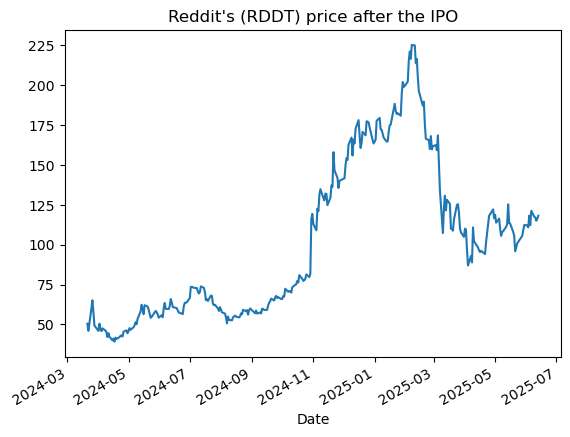

In [28]:
reddit['Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

In [29]:
# Fix for the IPO data processing issue

# 1. Improved version of get_first_n_trading_days with better date handling
def get_first_n_trading_days_fixed(ticker: str, ipo_date, n: int = 10) -> pd.Series:
    """
    Return a Series of 'Adj Close' prices for the first `n` trading days
    *starting with* the first day on or after `ipo_date`.
    Empty Series if retrieval fails or insufficient data.
    """
    # Make sure ipo_date is a pandas Timestamp
    if isinstance(ipo_date, str):
        try:
            ipo_date = pd.to_datetime(ipo_date)
        except:
            return pd.Series(dtype=float)
        
    try:
        # Fetch data around the IPO date
        start = ipo_date - pd.Timedelta(days=5)
        end = ipo_date + pd.Timedelta(days=85)
        
        # Download data
        px = yf.download(ticker, start=start, end=end, progress=False)
        
        # Handle empty results
        if px.empty:
            return pd.Series(dtype=float)
            
        # Check for Adj Close column
        if "Adj Close" not in px.columns:
            if "Close" in px.columns:  # Try to use Close if Adj Close is not available
                adj_close = px["Close"]
            else:
                return pd.Series(dtype=float)
        else:
            adj_close = px["Adj Close"]
            
        # Filter to days on or after IPO date
        px_filtered = adj_close[adj_close.index >= ipo_date].sort_index()
            
        # Reduce required trading days - lowering from the original 31+ days requirement
        if len(px_filtered) < n:
            return pd.Series(dtype=float)
        
        return px_filtered.iloc[:n]
        
    except Exception:
        return pd.Series(dtype=float)

In [31]:
# 2. Fixed version of the harvest_prices function with better handling of IPO data
def harvest_prices_fixed(ipo_df: pd.DataFrame, n: int = 10) -> dict:
    """
    Harvest price data for tickers in ipo_df.
    """
    prices = {}
    success_count = 0
    
    for _, row in tqdm(ipo_df.iterrows(), total=len(ipo_df), desc="download"):
        # Make sure we have a valid ticker symbol
        ticker = str(row["Symbol"]).strip().upper()
        
        # Get price data
        ts = get_first_n_trading_days_fixed(ticker, row["IPO Date"], n)
        
        if not ts.empty:
            prices[ticker] = ts
            success_count += 1
    
    print(f"Successfully downloaded {success_count}/{len(ipo_df)} tickers")
    return prices

# 3. Now let's apply the fixed functions to get usable tickers
print("Processing 2023 IPOs...")
prices23 = harvest_prices_fixed(ipos_2023, n=31)  # Reduced from 31 to 10 required days

print("Processing 2024 IPOs...")
prices24 = harvest_prices_fixed(ipos_2024, n=31)

print("Processing 2025 IPOs...")
prices25 = harvest_prices_fixed(ipos_2025, n=31)

print(f"Usable 2023 tickers: {len(prices23)}, usable 2024: {len(prices24)}, usable 2025: {len(prices25)}")

Processing 2023 IPOs...


download:   1%|          | 1/153 [00:00<00:21,  7.14it/s]

YF.download() has changed argument auto_adjust default to True


download:  29%|██▉       | 44/153 [00:06<00:16,  6.76it/s]
1 Failed download:
['RYZB']: YFTzMissingError('possibly delisted; no timezone found')
download:  33%|███▎      | 50/153 [00:07<00:14,  6.96it/s]
1 Failed download:
['NNAG']: YFTzMissingError('possibly delisted; no timezone found')
download:  33%|███▎      | 51/153 [00:07<00:25,  4.05it/s]
1 Failed download:
['SPGC']: YFTzMissingError('possibly delisted; no timezone found')
download:  35%|███▍      | 53/153 [00:08<00:23,  4.33it/s]
1 Failed download:
['LQR']: YFTzMissingError('possibly delisted; no timezone found')
download:  38%|███▊      | 58/153 [00:09<00:15,  5.96it/s]
1 Failed download:
['HRYU']: YFTzMissingError('possibly delisted; no timezone found')
download:  39%|███▊      | 59/153 [00:09<00:17,  5.27it/s]
1 Failed download:
['PXDT']: YFTzMissingError('possibly delisted; no timezone found')
download:  42%|████▏     | 65/153 [00:10<00:12,  6.93it/s]
1 Failed download:
['WRNT']: YFTzMissingError('possibly delisted; no tim

Successfully downloaded 117/153 tickers
Processing 2024 IPOs...


download:   8%|▊         | 17/225 [00:02<00:26,  7.91it/s]
1 Failed download:
['SPHA']: YFTzMissingError('possibly delisted; no timezone found')
download:  15%|█▍        | 33/225 [00:05<00:53,  3.60it/s]
1 Failed download:
['IZTC']: YFTzMissingError('possibly delisted; no timezone found')
download:  67%|██████▋   | 150/225 [00:23<00:10,  7.07it/s]
1 Failed download:
['HDL']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
download:  84%|████████▎ | 188/225 [00:38<00:05,  7.33it/s]
1 Failed download:
['LOBO']: Timeout('Failed to perform, curl: (28) Connection timed out after 10003 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')
download:  87%|████████▋ | 195/225 [00:49<00:14,  2.09it/s]
1 Failed download:
['VHAI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-02-17 00:00:00 -> 2024-05-17 00:00:00) (Yahoo err

Successfully downloaded 178/225 tickers
Processing 2025 IPOs...


download:   0%|          | 0/152 [00:00<?, ?it/s]
1 Failed download:
['AIRO']: YFInvalidPeriodError("AIRO: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
download:   1%|          | 1/152 [00:00<00:28,  5.29it/s]
1 Failed download:
['BACC']: YFTzMissingError('possibly delisted; no timezone found')
download:   1%|▏         | 2/152 [00:00<00:36,  4.08it/s]
1 Failed download:
['BSAA']: YFTzMissingError('possibly delisted; no timezone found')
download:   5%|▍         | 7/152 [00:01<00:30,  4.69it/s]
1 Failed download:
['BLUW']: YFTzMissingError('possibly delisted; no timezone found')
download:   8%|▊         | 12/152 [00:02<00:24,  5.60it/s]
1 Failed download:
['JENA']: YFInvalidPeriodError("JENA: Period 'max' is invalid, must be of the format 1d, 5d, etc.")
download:   9%|▊         | 13/152 [00:02<00:22,  6.27it/s]
1 Failed download:
['WTG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-05-24 00:00:00 -> 2025-08-22 00:00:00)')
download:   9%|▉      

Successfully downloaded 84/152 tickers
Usable 2023 tickers: 117, usable 2024: 178, usable 2025: 84


In [32]:

prices23

{'LGCB': Ticker           LGCB
 Date                 
 2023-12-19  31.200001
 2023-12-20  26.809999
 2023-12-21  23.400000
 2023-12-22  20.400000
 2023-12-26  19.600000
 2023-12-27  15.900000
 2023-12-28  17.200001
 2023-12-29  15.600000
 2024-01-02  16.559999
 2024-01-03  16.340000
 2024-01-04  16.840000
 2024-01-05  18.200001
 2024-01-08  17.100000
 2024-01-09  15.800000
 2024-01-10  14.600000
 2024-01-11  14.200000
 2024-01-12  15.000000
 2024-01-16  15.200000
 2024-01-17  16.469999
 2024-01-18  16.400000
 2024-01-19  15.200000
 2024-01-22  14.500000
 2024-01-23  14.300000
 2024-01-24  13.900000
 2024-01-25  15.800000
 2024-01-26  15.400000
 2024-01-29  15.490000
 2024-01-30  17.840000
 2024-01-31  16.900000
 2024-02-01  16.299999
 2024-02-02  16.000000,
 'BAYA': Ticker        BAYA
 Date              
 2023-12-29  10.010
 2024-01-02  10.020
 2024-01-03  10.050
 2024-01-04  10.060
 2024-01-05  10.060
 2024-01-08  10.060
 2024-01-09  10.079
 2024-01-10  10.072
 2024-01-11  10.070
 202

In [34]:
import numpy as np
import pandas as pd

def make_return_matrix_fixed(price_dict: dict, max_horizon: int = 30) -> pd.DataFrame:
    """
    Rows: tickers, Cols: day-X total return (AdjClose_t / AdjClose_0 − 1).

    Handles both Series and single-column DataFrames coming from yfinance,
    and fills missing horizons with NaN.
    """
    # Pre-allocate
    mat = pd.DataFrame(
        index=price_dict.keys(),
        columns=range(1, max_horizon + 1),
        dtype=float
    )

    for tkr, px in price_dict.items():
        # --- Ensure we are working with a 1-D Series of floats -------------
        if isinstance(px, pd.DataFrame):
            px = px.iloc[:, 0]      # take the lone column
        px = px.dropna()
        if px.empty:
            continue

        base = float(px.iloc[0])    # scalar
        for x in mat.columns:
            if x < len(px):
                mat.loc[tkr, x] = float(px.iloc[x]) / base - 1.0
            else:
                mat.loc[tkr, x] = np.nan   # horizon not available

    return mat

In [35]:

# Use this fixed function with your price data
rets23 = make_return_matrix_fixed(prices23)
rets24 = make_return_matrix_fixed(prices24)
rets25 = make_return_matrix_fixed(prices25)

# Verify the results
print(f"Return matrix shapes - 2023: {rets23.shape}, 2024: {rets24.shape}, 2025: {rets25.shape}")

Return matrix shapes - 2023: (117, 30), 2024: (178, 30), 2025: (84, 30)



### Optimise X on the 2023 cohort

In [37]:

mean_by_x = rets23.mean(axis=0)            # equal-weighted mean
opt_x = mean_by_x.idxmax()                 # integer between 1 and 30
opt_return23 = mean_by_x.max()

print(f"Optimal holding period (2023): X = {opt_x} trading days")
print(f"Mean total return @ X={opt_x}: {opt_return23:.2%}")

Optimal holding period (2023): X = 1 trading days
Mean total return @ X=1: -6.68%


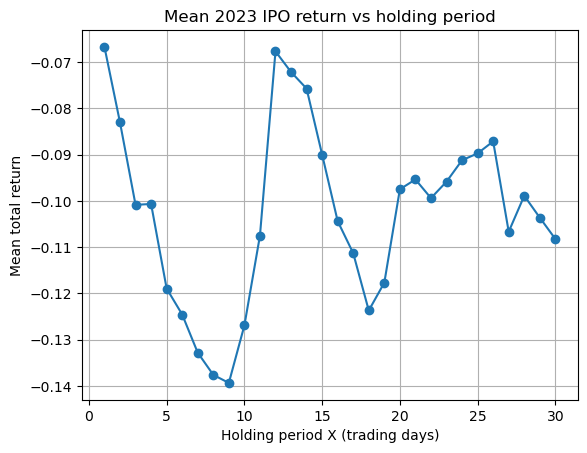

In [38]:

import matplotlib.pyplot as plt

mean_by_x.plot(marker="o", title="Mean 2023 IPO return vs holding period")
plt.xlabel("Holding period X (trading days)")
plt.ylabel("Mean total return")
plt.grid(True)
plt.show()


### Return distribution at the optimal horizon

In [39]:
dist23 = rets23[opt_x].dropna()
q25, q50, q75 = dist23.quantile([0.25, 0.50, 0.75])
mean23        = dist23.mean()

print(f"Distribution @ X={opt_x}:")
print(f"  25-percentile: {q25:.2%}")
print(f"  Median (50%): {q50:.2%}")
print(f"  75-percentile: {q75:.2%}")
print(f"  Mean:          {mean23:.2%}")

if q25 < 0:
    print("→ At least 25 % of the deals lose money over this horizon.")

Distribution @ X=1:
  25-percentile: -13.88%
  Median (50%): -2.03%
  75-percentile: 1.91%
  Mean:          -6.68%
→ At least 25 % of the deals lose money over this horizon.



### Out-of-sample test on 2024 IPOs

In [40]:

dist24 = rets24[opt_x].dropna()
mean24 = dist24.mean()

print(f"\n2024 cohort, same X={opt_x} days:")
print(f"  Mean total return: {mean24:.2%}")
print(f"  Difference vs 2023: {(mean24 - mean23):+.2%}")


2024 cohort, same X=1 days:
  Mean total return: 1.88%
  Difference vs 2023: +8.55%


In [41]:

dist25 = rets25[opt_x].dropna()
mean25 = dist25.mean()

print(f"\n2025 cohort, same X={opt_x} days:")
print(f"  Mean total return: {mean25:.2%}")
print(f"  Difference vs 2023: {(mean25 - mean23):+.2%}")


2025 cohort, same X=1 days:
  Mean total return: -1.18%
  Difference vs 2023: +5.49%


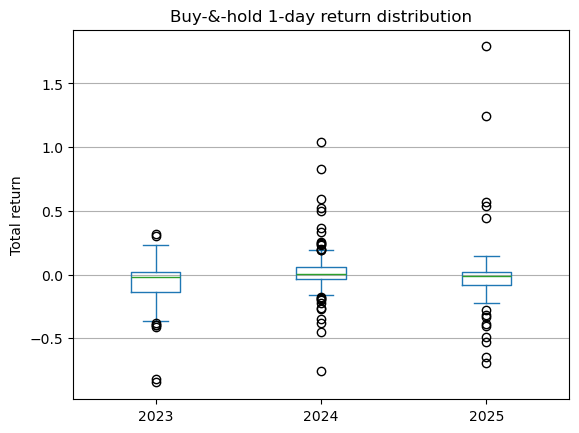

In [42]:

box_df = pd.DataFrame({
    "2023": dist23,
    "2024": dist24,
    "2025": dist25
})
box_df.plot.box(title=f"Buy-&-hold {opt_x}-day return distribution")
plt.ylabel("Total return")
plt.grid(True, axis='y')
plt.show()

In [43]:

print(f"""

Optimal X  (2023 equal-weighted mean maximiser) : {opt_x}
Mean return 2023 @X                             : {mean23:.2%}
25-/50-/75-percentiles                          : {q25:.2%} | {q50:.2%} | {q75:.2%}
Losing-money in ≥25 % of cases?                 : {"YES" if q25 < 0 else "NO"}
Mean return 2024 @same X                        : {mean24:.2%}   (Δ {mean24 - mean23:+.2%})
""")



Optimal X  (2023 equal-weighted mean maximiser) : 1
Mean return 2023 @X                             : -6.68%
25-/50-/75-percentiles                          : -13.88% | -2.03% | 1.91%
Losing-money in ≥25 % of cases?                 : YES
Mean return 2024 @same X                        : 1.88%   (Δ +8.55%)



# 2) OHLCV data transformations

## 2.1 [Code Snippet 2] Time series for OHLCV

In [44]:
ticker_obj = yf.Ticker("NVO")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [45]:
# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11122 entries, 1981-04-30 00:00:00-04:00 to 2025-06-13 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11122 non-null  float64
 1   High          11122 non-null  float64
 2   Low           11122 non-null  float64
 3   Close         11122 non-null  float64
 4   Volume        11122 non-null  int64  
 5   Dividends     11122 non-null  float64
 6   Stock Splits  11122 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 695.1 KB


In [46]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10562500,0.0,0.0
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.430000,79.830002,7467200,0.0,0.0


In [47]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

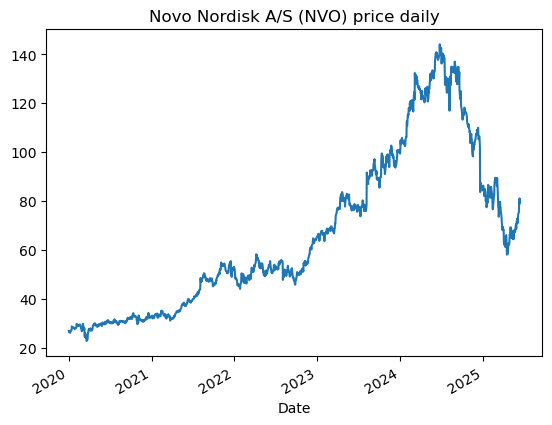

In [48]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')

In [49]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [50]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0,NVO,2025,6,0,2025-06-09
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0,NVO,2025,6,1,2025-06-10
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0,NVO,2025,6,2,2025-06-11
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10562500,0.0,0.0,NVO,2025,6,3,2025-06-12
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.430000,79.830002,7467200,0.0,0.0,NVO,2025,6,4,2025-06-13


In [51]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['close_minus_1'] = nvo_df['Close'].shift(-1)
nvo_df['close_plus_1'] = nvo_df['Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,close_minus_1,close_plus_1
Date,,,,,,,,,,,,,,
2025-06-09 00:00:00-04:00,75.010002,76.849998,74.160004,75.459999,10885800,0.0,0.0,NVO,2025,6,0,2025-06-09,79.330002,74.629997
2025-06-10 00:00:00-04:00,77.989998,80.440002,77.440002,79.330002,13076800,0.0,0.0,NVO,2025,6,1,2025-06-10,78.730003,75.459999
2025-06-11 00:00:00-04:00,79.080002,79.830002,78.339996,78.730003,9211600,0.0,0.0,NVO,2025,6,2,2025-06-11,81.050003,79.330002
2025-06-12 00:00:00-04:00,80.639999,81.160004,79.919998,81.050003,10562500,0.0,0.0,NVO,2025,6,3,2025-06-12,79.830002,78.730003
2025-06-13 00:00:00-04:00,81.410004,81.440002,79.430000,79.830002,7467200,0.0,0.0,NVO,2025,6,4,2025-06-13,NaN,81.050003


In [52]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Close'] / nvo_df['Close'].shift(1)           # nvo_df['close_plus_1']
nvo_df['growth_30d'] = nvo_df['Close'] / nvo_df['Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Close'].shift(-1) / nvo_df['Close']   # nvo_df['close_minus_1']
nvo_df['growth_future_30d'] = nvo_df['Close'].shift(-30) / nvo_df['Close']   # nvo_df['close_minus_1']


# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)
nvo_df['is_positive_growth_30d_future'] = np.where(nvo_df['growth_future_30d'] > 1, 1, 0)


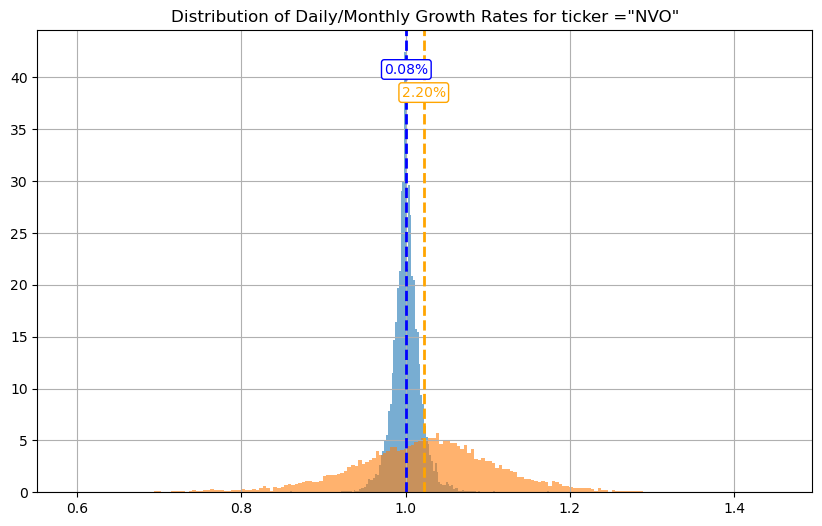

In [53]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.figure(figsize=(10, 6))
plt.title('Distribution of Daily/Monthly Growth Rates for ticker ="NVO"')

nvo_df.growth_1d.hist(bins=200, alpha=0.6, density=True)
nvo_df.growth_30d.hist(bins=200, alpha=0.6, density=True)

# Add vertical lines for averages
mean_1d = nvo_df.growth_1d.mean()
mean_30d = nvo_df.growth_30d.mean()

plt.axvline(mean_1d, color='blue', linestyle='--', linewidth=2, label=f'1d avg = {mean_1d:.3f}')
plt.axvline(mean_30d, color='orange', linestyle='--', linewidth=2, label=f'30d avg = {mean_30d:.3f}')


# Add mean text labels (as percent change)
ymax = plt.ylim()[1]
plt.text(mean_1d, ymax * 0.90,
         f'{(mean_1d - 1) * 100:.2f}%',
         color='blue', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'))

plt.text(mean_30d, ymax * 0.85,
         f'{(mean_30d - 1) * 100:.2f}%',
         color='orange', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))


plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

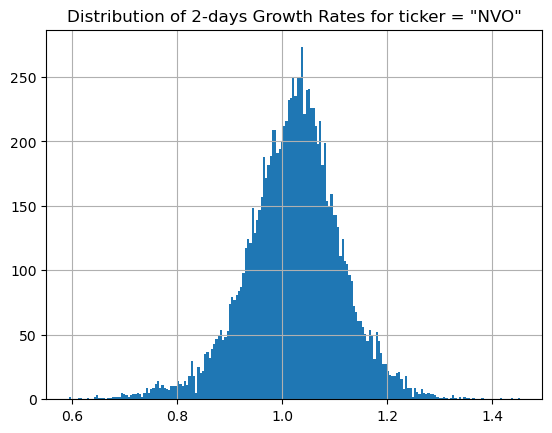

In [54]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [55]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Close']
nvo_df[COLUMNS].tail()

,Close,growth_1d,growth_30d,growth_future_1d,growth_future_30d,is_positive_growth_1d_future,is_positive_growth_30d_future
Date,,,,,,,
2025-06-09 00:00:00-04:00,75.459999,1.011122,1.215528,1.051285,NaN,1,0
2025-06-10 00:00:00-04:00,79.330002,1.051285,1.266848,0.992437,NaN,0,0
2025-06-11 00:00:00-04:00,78.730003,0.992437,1.208257,1.029468,NaN,1,0
2025-06-12 00:00:00-04:00,81.050003,1.029468,1.219714,0.984948,NaN,0,0
2025-06-13 00:00:00-04:00,79.830002,0.984948,1.216921,NaN,NaN,0,0


In [56]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.512857
1    0.487143
Name: count, dtype: float64

In [57]:
nvo_df.is_positive_growth_30d_future.value_counts() / len(nvo_df)

is_positive_growth_30d_future
1    0.619942
0    0.380058
Name: count, dtype: float64

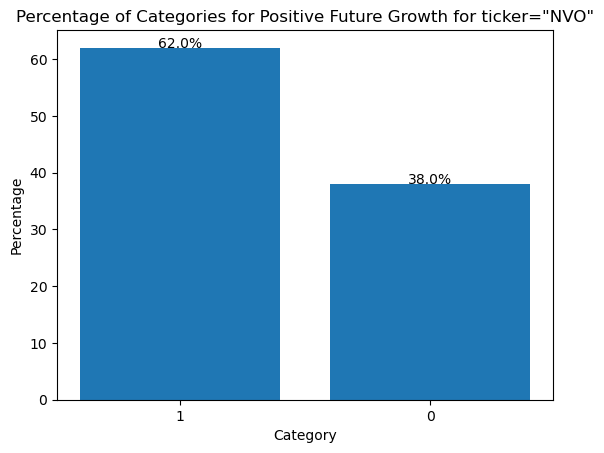

In [58]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_30d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2) [Code Snippet 6] Candlestick chart for OHLCV

In [59]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

# 3) Macro Indicators

## 3.0) Previous indicators from module 1

In [60]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=14
Period for indexes: 1955-06-14 to 2025-06-14 


In [61]:
# reuse code for ealier covered indicators
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [62]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [63]:
dax_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
1987-12-30 00:00:00+01:00,1005.190002,1005.190002,1005.190002,1005.190002,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04 00:00:00+01:00,956.489990,956.489990,956.489990,956.489990,0,0.0,0.0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05 00:00:00+01:00,996.099976,996.099976,996.099976,996.099976,0,0.0,0.0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06 00:00:00+01:00,1006.010010,1006.010010,1006.010010,1006.010010,0,0.0,0.0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07 00:00:00+01:00,1014.469971,1014.469971,1014.469971,1014.469971,0,0.0,0.0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [64]:
dax_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-12 00:00:00+02:00,23768.050781,23885.060547,23618.849609,23771.449219,63677900,0.0,0.0,0.992590,0.983335,0.986710,1.056651,1.109351,1.437350
2025-06-13 00:00:00+02:00,23448.189453,23557.710938,23360.160156,23516.230469,73193600,0.0,0.0,0.989264,0.980351,0.968684,1.018607,1.093488,1.415166


In [65]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-13 00:00:00+02:00,0.989264,0.980351,0.968684,1.018607,1.093488,1.415166


In [66]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [67]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

# snp500_daily = yf.download(tickers = "^GSPC",
#                      period = "max",
#                      interval = "1d")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [68]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,1.003822,1.006557,1.012544,1.085508,1.008456,1.264281
2025-06-13 00:00:00-04:00,0.988704,0.989760,1.001032,1.066528,0.989912,1.249536


In [81]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

# dji_daily = yf.download(tickers = "^DJI",
#                      period = "max",
#                      interval = "1d")


dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [70]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,1.002376,1.004814,1.010536,1.056511,0.967262,1.141041
2025-06-13 00:00:00-04:00,0.982083,0.984392,0.994580,1.035453,0.947072,1.119005


In [71]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

# epi_etf_daily = yf.download(tickers = "EPI",
#                      period = "max",
#                      interval = "1d")

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-12 00:00:00-04:00,46.820000,46.93,46.770000,46.900002,592100,0.0,0.0,0.0
2025-06-13 00:00:00-04:00,46.130001,46.41,46.130001,46.270000,971700,0.0,0.0,0.0


In [72]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,0.991334,0.997448,1.018458,1.034863,1.083892,1.147758
2025-06-13 00:00:00-04:00,0.986567,0.980504,1.005651,1.021413,1.056634,1.124381


In [73]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2025-01-01,23243.22,0.023113,0.005619
2025-04-01,23376.07,0.023029,0.005716


In [74]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [75]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2025-04-01,326.430,0.027815,0.002368
2025-05-01,326.854,0.027671,0.001299


In [76]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368
2025-05-01,0.027671,0.001299


In [77]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)

,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [78]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)

,DGS1
DATE,
2025-06-11,4.08
2025-06-12,4.06


In [79]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-11,4.02
2025-06-12,3.97


In [80]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)

,DGS10
DATE,
2025-06-11,4.41
2025-06-12,4.36


## 3.1) [Code snippet 3] VIX - Volatility Index

In [82]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [83]:
vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-12 00:00:00-05:00,17.870001,18.870001,17.430000,18.02,0,0.0,0.0
2025-06-13 00:00:00-05:00,21.760000,22.000000,18.879999,20.82,0,0.0,0.0


In [84]:
vix_to_merge = vix['Close']
vix_to_merge.tail()

Date
2025-06-09 00:00:00-05:00    17.160000
2025-06-10 00:00:00-05:00    16.950001
2025-06-11 00:00:00-05:00    17.260000
2025-06-12 00:00:00-05:00    18.020000
2025-06-13 00:00:00-05:00    20.820000
Name: Close, dtype: float64

<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

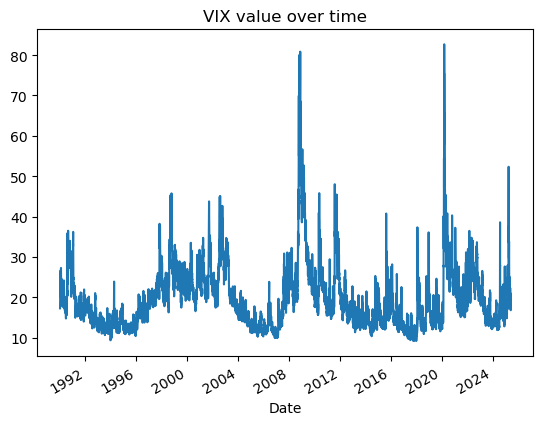

In [85]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Close'].plot.line(title = "VIX value over time")

In [86]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2) Gold - other assets

In [87]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

# gold = yf.download(tickers = "GC=F",
#                      period = "max",
#                      interval = "1d")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [88]:
gold.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00-04:00,3407.300049,3444.0,3407.300049,3431.199951,1818,0.0,0.0


In [89]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,1.017945,1.014645,1.009164,1.022965,1.193020,1.630214
2025-06-13 00:00:00-04:00,1.014878,1.033214,1.017104,1.068910,1.202537,1.663693


In [90]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3) WTI Crude and Brent Oil

In [92]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

# crude_oil = yf.download(tickers = "CL=F",
#                      period = "max",
#                      interval = "1d")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [93]:
crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-12 00:00:00-04:00,69.029999,69.290001,66.720001,68.040001,379394,0.0,0.0
2025-06-13 00:00:00-04:00,68.900002,77.620003,68.489998,72.980003,379394,0.0,0.0


In [94]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,0.998386,1.042120,1.073017,1.168871,0.930016,0.948028
2025-06-13 00:00:00-04:00,1.072604,1.123115,1.161177,1.231938,1.003852,1.018562


In [95]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [96]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-12 00:00:00-04:00,70.360001,70.610001,68.370003,69.360001,60336,0.0,0.0
2025-06-13 00:00:00-04:00,70.269997,78.529999,69.919998,74.230003,60336,0.0,0.0


In [97]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-12 00:00:00-04:00,0.994124,1.034606,1.056834,1.098859,0.913112,0.884807
2025-06-13 00:00:00-04:00,1.070213,1.110064,1.144465,1.194753,0.974147,0.963525


In [98]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4) Bitcoin prices: BTC_USD

In [103]:
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

# btc_usd =  yf.download(tickers = "BTC-USD",
#                      period = "max",
#                      interval = "1d")


btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-13 00:00:00+00:00,105924.59375,106182.546875,102822.023438,106090.96875,69550440846,0.0,0.0
2025-06-14 00:00:00+00:00,106109.46875,106109.468750,104933.320312,105075.50000,49462222848,0.0,0.0


In [104]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-13 00:00:00+00:00,1.001529,0.962213,1.016291,1.024643,1.257850,1.589225
2025-06-14 00:00:00+00:00,0.990428,0.966775,0.994886,1.012828,1.272413,1.591785


In [105]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"


In [106]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [107]:
import eurostat

In [109]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [110]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2025-05-02_value  2148 non-null   float64
 6   2025-05-02_flag   2148 non-null   object 
 7   2025-05-05_value  2148 non-null   float64
 8   2025-05-05_flag   2148 non-null   object 
 9   2025-05-06_value  2148 non-null   float64
 10  2025-05-06_flag   2148 non-null   object 
 11  2025-05-07_value  2148 non-null   float64
 12  2025-05-07_flag   2148 non-null   object 
 13  2025-05-08_value  2148 non-null   float64
 14  2025-05-08_flag   2148 non-null   object 
 15  2025-05-09_value  2148 non-null   float64
 16  2025-05-09_flag   2148 non-null   object 


In [111]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,


In [112]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [113]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [114]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [115]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.56000,,2.58380,,2.61680,...,2.63569,,2.60094,,2.61034,,2.57690,,2.57548,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09194,,3.11837,,3.15733,...,3.13756,,3.09442,,3.10789,,3.06678,,3.07015,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.56737,,2.59130,,2.62451,...,2.64314,,2.60802,,2.61738,,2.58400,,2.58254,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10140,,3.12818,,3.16710,...,3.14705,,3.10358,,3.11705,,3.07587,,3.07933,


In [116]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [117]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(20)

,maturity,2025-05-05_value
1433,M10,1.79463
1435,M11,1.78389
1437,M3,1.91227
1439,M4,1.89037
1441,M5,1.87031
1443,M6,1.85200
1445,M7,1.83535
1447,M8,1.82029
1449,M9,1.80674
1451,Y1,1.77444


In [118]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(20)

,maturity,2025-05-29_value
1433,M10,1.78884
1435,M11,1.78214
1437,M3,1.86951
1439,M4,1.85393
1441,M5,1.83981
1443,M6,1.82708
1445,M7,1.81569
1447,M8,1.80555
1449,M9,1.79662
1451,Y1,1.77647


In [119]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [121]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

In [122]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

,maturity,maturity_in_months,2025-05-29_value
1437,M3,3,1.86951
1439,M4,4,1.85393
1441,M5,5,1.83981
1443,M6,6,1.82708
1445,M7,7,1.81569
1447,M8,8,1.80555
1449,M9,9,1.79662
1433,M10,10,1.78884
1435,M11,11,1.78214
1451,Y1,12,1.77647


In [123]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

/var/folders/94/c9w07ypn0s31_b9lsdglwwnw0000gn/T/ipykernel_23414/2163179308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

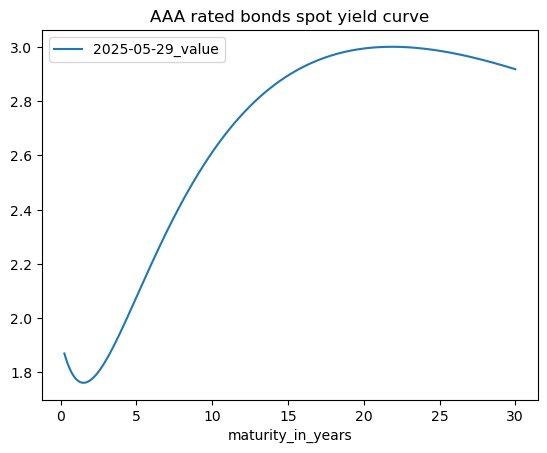

In [124]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
  .plot.line(x='maturity_in_years',
            y='2025-05-29_value',
            title='AAA rated bonds spot yield curve')

# 4) [Code Snippet 5] Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [ ]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [ ]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
# WMT ticker
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

In [ ]:
one_company.calendar

In [ ]:
one_company.financials

In [ ]:
EPS = one_company.financials.loc['Basic EPS']
EPS

In [ ]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']

In [ ]:
EBITDA_margin

In [ ]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']

In [ ]:
NET_INCOME

In [ ]:
# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin

In [ ]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

In [ ]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [ ]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [ ]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

In [ ]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

In [ ]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


In [ ]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [ ]:
# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

In [ ]:
# unique tickers
stocks_df.Ticker.nunique()

In [ ]:
# count of observations by stock
stocks_df.Ticker.value_counts()

In [ ]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

In [ ]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

In [ ]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [ ]:
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

In [ ]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

#6) [Code Snippet 8] Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [ ]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib

In [ ]:
# [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
!rm -rf /usr/local/lib/python3.11/dist-packages/talib

!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

## 6.1) Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [ ]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [ ]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3) Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [ ]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

## 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [ ]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [ ]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [ ]:
stocks_df.info()

In [ ]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

In [ ]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

In [ ]:
merged_df_with_tech_ind.info()

# 7) [Code snippet 9] Merge All Together

In [ ]:
merged_df_with_tech_ind.head(1)

In [ ]:
merged_df_with_tech_ind.shape

In [ ]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [ ]:
# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)

In [ ]:
dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)

In [ ]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m2.tail(1)

In [ ]:
# check the same number of records, but columns increased
m2.shape

In [ ]:
# merge with dax_daily_to_merge
snp500_to_merge.tail(1)

In [ ]:
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)

In [ ]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m3.tail(1)

In [ ]:
m3.shape

In [ ]:
dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)

In [ ]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m4.shape

In [ ]:
m4.tail(1)

In [ ]:
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)

In [ ]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m5.shape

In [ ]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

In [ ]:
gdppot_to_merge.tail(1)

In [ ]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m6.tail(2)

In [ ]:
m6.shape

In [ ]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

In [ ]:
cpilfesl_to_merge.tail(1)

In [ ]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# PROBLEM! Last month is not defined
m7.tail(1)

In [ ]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()


In [ ]:
m7.tail(1)

In [ ]:
fedfunds.tail(1)

In [ ]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m8.tail(1)

In [ ]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()


In [ ]:
m8.tail(1)

In [ ]:
dgs1.tail(1)

In [ ]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# fix last day later
m9.tail(2)

In [ ]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
# fix last day later
m10.tail(2)

In [ ]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m11.tail(2)

In [ ]:
vix_to_merge

In [ ]:
vix_to_merge.index = vix_to_merge.index.tz_localize(None)

In [ ]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m12.tail(2)

In [ ]:
gold_to_merge.tail(2)

In [ ]:
gold_to_merge.index = gold_to_merge.index.tz_localize(None)

In [ ]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m13.tail(2)

In [ ]:
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)

In [ ]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m14.tail(2)

In [ ]:
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)

In [ ]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m15.tail(2)

In [ ]:
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [ ]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [ ]:
m16.tail(2)

In [ ]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [ ]:
m16.tail(2)

In [ ]:
m16.info()

In [ ]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

In [ ]:
m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')